In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 977.3/977.3 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from ultralytics import YOLO
import cv2
import os
import glob

# Paths
full_image_dir = "/content/drive/MyDrive/Syook/datasets/data_split/images/train"  # or val
output_crop_dir = "/content/drive/MyDrive/Syook/datasets/data_split/crops/images"
output_label_dir = "/content/drive/MyDrive/Syook/datasets/data_split/crops/labels"

os.makedirs(output_crop_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

# Load model (person + PPE)
model = YOLO("/content/drive/MyDrive/Syook/datasets/runs/detect/train2/weights/best.pt")

# Class index for person and PPE
PERSON_CLASS_ID = 0
PPE_CLASSES = list(range(1, 10))

# Helper to convert YOLO bbox to absolute coords
def yolo_to_abs(xc, yc, w, h, img_w, img_h):
    x1 = int((xc - w / 2) * img_w)
    y1 = int((yc - h / 2) * img_h)
    x2 = int((xc + w / 2) * img_w)
    y2 = int((yc + h / 2) * img_h)
    return x1, y1, x2, y2

# Main loop
image_paths = glob.glob(os.path.join(full_image_dir, "*.jpg"))
print(f"Found {len(image_paths)} images.")

for img_path in image_paths:
    img = cv2.imread(img_path)
    img_h, img_w = img.shape[:2]
    base_name = os.path.splitext(os.path.basename(img_path))[0]

    results = model(img_path, verbose=False)[0]
    boxes = results.boxes
    if boxes is None:
        continue

    person_idx = 0
    for box in boxes:
        cls = int(box.cls)
        if cls != PERSON_CLASS_ID:
            continue  # only crop person class

        x1, y1, x2, y2 = map(int, box.xyxy[0])
        x1, y1 = max(x1, 0), max(y1, 0)
        x2, y2 = min(x2, img_w), min(y2, img_h)
        crop = img[y1:y2, x1:x2]

        crop_name = f"{base_name}_person{person_idx}.jpg"
        crop_path = os.path.join(output_crop_dir, crop_name)
        cv2.imwrite(crop_path, crop)
        person_idx += 1

        # Re-run inference on cropped person image
        crop_results = model(crop, verbose=False)[0]
        crop_boxes = crop_results.boxes
        if crop_boxes is None:
            continue

        # Save PPE annotations in YOLO format
        label_lines = []
        for b in crop_boxes:
            c = int(b.cls)
            if c == PERSON_CLASS_ID:
                continue  # skip person detection in PPE cropped image

            x1_, y1_, x2_, y2_ = map(int, b.xyxy[0])
            cx = (x1_ + x2_) / 2 / crop.shape[1]
            cy = (y1_ + y2_) / 2 / crop.shape[0]
            bw = (x2_ - x1_) / crop.shape[1]
            bh = (y2_ - y1_) / crop.shape[0]
            label_lines.append(f"{c} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}")

        if label_lines:
            label_path = os.path.join(output_label_dir, crop_name.replace(".jpg", ".txt"))
            with open(label_path, "w") as f:
                f.write("\n".join(label_lines))
            print(f"✅ Saved: {crop_name} with {len(label_lines)} PPE items.")
        else:
            print(f"⚠️ Skipped {crop_name} (no PPE detected)")

print("✅ All done! Cropped person images and PPE labels are generated.")

Found 332 images.
✅ Saved: 001807_person0.jpg with 3 PPE items.
✅ Saved: 001807_person1.jpg with 1 PPE items.
⚠️ Skipped 001807_person2.jpg (no PPE detected)
✅ Saved: 005154_person0.jpg with 3 PPE items.
✅ Saved: 005154_person1.jpg with 2 PPE items.
✅ Saved: 005154_person2.jpg with 3 PPE items.
✅ Saved: 005154_person3.jpg with 2 PPE items.
✅ Saved: 001186_person0.jpg with 3 PPE items.
✅ Saved: 001186_person1.jpg with 2 PPE items.
✅ Saved: 001186_person2.jpg with 1 PPE items.
✅ Saved: 001852_person0.jpg with 3 PPE items.
✅ Saved: 001631_person0.jpg with 5 PPE items.
✅ Saved: 001302_person0.jpg with 2 PPE items.
✅ Saved: 001302_person1.jpg with 2 PPE items.
⚠️ Skipped 001302_person2.jpg (no PPE detected)
✅ Saved: 001302_person3.jpg with 3 PPE items.
✅ Saved: -2082-_png_jpg.rf.7b89e77b67643cd28c0ce52ed7e588e3_person0.jpg with 1 PPE items.
✅ Saved: -2082-_png_jpg.rf.7b89e77b67643cd28c0ce52ed7e588e3_person1.jpg with 1 PPE items.
⚠️ Skipped -2082-_png_jpg.rf.7b89e77b67643cd28c0ce52ed7e588e3_

In [ ]:
from ultralytics import YOLO
import cv2
import os
import glob

# ==== CONFIG ====
full_image_dir = "/content/drive/MyDrive/Syook/datasets/data_split/images/train"  # or val
output_crop_dir = "/content/drive/MyDrive/Syook/datasets/data_split/PPE_train_data/images"
output_label_dir = "/content/drive/MyDrive/Syook/datasets/data_split/PPE_train_data/labels"
model_path = "/content/drive/MyDrive/Syook/datasets/runs/detect/train2/weights/best.pt"

# ==== SETUP ====
os.makedirs(output_crop_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)
model = YOLO(model_path)

PERSON_CLASS_ID = 0
PPE_CLASSES = list(range(1, 10))  # PPE class IDs

image_paths = glob.glob(os.path.join(full_image_dir, "*.jpg"))
print(f"📸 Found {len(image_paths)} full images.")

total_crops = 0
labeled_crops = 0
empty_label_crops = 0

for img_path in image_paths:
    img = cv2.imread(img_path)
    if img is None:
        print(f"❌ Could not read {img_path}")
        continue

    img_h, img_w = img.shape[:2]
    base_name = os.path.splitext(os.path.basename(img_path))[0]

    # Run person + PPE detection
    results = model(img_path, verbose=False)[0]
    boxes = results.boxes

    if boxes is None:
        continue

    person_idx = 0
    for box in boxes:
        cls = int(box.cls)
        if cls != PERSON_CLASS_ID:
            continue

        # Crop person
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        x1, y1 = max(x1, 0), max(y1, 0)
        x2, y2 = min(x2, img_w), min(y2, img_h)
        crop = img[y1:y2, x1:x2]

        crop_name = f"{base_name}_person{person_idx}.jpg"
        crop_path = os.path.join(output_crop_dir, crop_name)
        label_path = os.path.join(output_label_dir, crop_name.replace(".jpg", ".txt"))

        person_idx += 1
        total_crops += 1

        # Run inference on cropped image
        crop_results = model(crop, verbose=False)[0]
        crop_boxes = crop_results.boxes

        label_lines = []
        if crop_boxes is not None:
            for b in crop_boxes:
                c = int(b.cls)
                if c == PERSON_CLASS_ID:
                    continue

                x1_, y1_, x2_, y2_ = map(int, b.xyxy[0])
                cx = (x1_ + x2_) / 2 / crop.shape[1]
                cy = (y1_ + y2_) / 2 / crop.shape[0]
                bw = (x2_ - x1_) / crop.shape[1]
                bh = (y2_ - y1_) / crop.shape[0]
                label_lines.append(f"{c} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}")

        # Save crop image
        cv2.imwrite(crop_path, crop)

        # Save label file (even if empty)
        with open(label_path, "w") as f:
            if label_lines:
                f.write("\n".join(label_lines))
                labeled_crops += 1
                print(f"✅ Saved: {crop_name} with {len(label_lines)} PPE items.")
            else:
                empty_label_crops += 1
                print(f"⚠️ Saved: {crop_name} (NO PPE detected)")

# ==== SUMMARY ====
print("\n🎯 Summary:")
print(f"👤 Total cropped person images: {total_crops}")
print(f"✅ Labeled crops (with PPE):     {labeled_crops}")
print(f"🚫 No PPE crops (empty labels):  {empty_label_crops}")
print("✅ Done.")

📸 Found 332 full images.
✅ Saved: 001807_person0.jpg with 3 PPE items.
✅ Saved: 001807_person1.jpg with 1 PPE items.
⚠️ Saved: 001807_person2.jpg (NO PPE detected)
✅ Saved: 005154_person0.jpg with 3 PPE items.
✅ Saved: 005154_person1.jpg with 2 PPE items.
✅ Saved: 005154_person2.jpg with 3 PPE items.
✅ Saved: 005154_person3.jpg with 2 PPE items.
✅ Saved: 001186_person0.jpg with 3 PPE items.
✅ Saved: 001186_person1.jpg with 2 PPE items.
✅ Saved: 001186_person2.jpg with 1 PPE items.
✅ Saved: 001852_person0.jpg with 3 PPE items.
✅ Saved: 001631_person0.jpg with 5 PPE items.
✅ Saved: 001302_person0.jpg with 2 PPE items.
✅ Saved: 001302_person1.jpg with 2 PPE items.
⚠️ Saved: 001302_person2.jpg (NO PPE detected)
✅ Saved: 001302_person3.jpg with 3 PPE items.
✅ Saved: -2082-_png_jpg.rf.7b89e77b67643cd28c0ce52ed7e588e3_person0.jpg with 1 PPE items.
✅ Saved: -2082-_png_jpg.rf.7b89e77b67643cd28c0ce52ed7e588e3_person1.jpg with 1 PPE items.
⚠️ Saved: -2082-_png_jpg.rf.7b89e77b67643cd28c0ce52ed7e58

In [ ]:
import os
import cv2
from google.colab.patches import cv2_imshow

# Paths
crop_img_dir = "/content/drive/MyDrive/Syook/datasets/data_split/PPE_train_data/images"
crop_lbl_dir = "/content/drive/MyDrive/Syook/datasets/data_split/PPE_train_data/labels"

# Get filenames without extensions
img_files = set(f.replace(".jpg", "") for f in os.listdir(crop_img_dir) if f.endswith(".jpg"))
lbl_files = set(f.replace(".txt", "") for f in os.listdir(crop_lbl_dir) if f.endswith(".txt"))

# Find images without labels
missing_labels = sorted(img_files - lbl_files)

print(f"🔍 Found {len(missing_labels)} cropped images without labels.")

# Display missing label images
for i, name in enumerate(missing_labels):
    img_path = os.path.join(crop_img_dir, name + ".jpg")
    img = cv2.imread(img_path)

    if img is not None:
        print(f"\n🖼️ Showing {i+1}/{len(missing_labels)}: {name}.jpg")
        cv2_imshow(img)
    else:
        print(f"⚠️ Could not load image: {img_path}")

🔍 Found 0 cropped images without labels.


In [ ]:
len(os.listdir('/content/drive/MyDrive/Syook/datasets/data_split/PPE_train_data/labels'))

1080

In [ ]:
len(os.listdir('/content/drive/MyDrive/Syook/datasets/data_split/PPE_train_data/images'))

1080

Total cropped images found: 1080
🖼️ Showing 005003_person3.jpg


🖼️ Showing 001223_person1.jpg


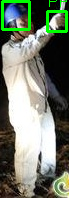

🖼️ Showing 001221_person4.jpg


🖼️ Showing 001837_person12.jpg


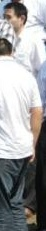

🖼️ Showing 001406_person1.jpg


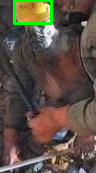

🖼️ Showing 005009_person2.jpg


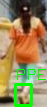

🖼️ Showing 001338_person2.jpg


🖼️ Showing 001236_person1.jpg


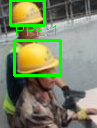

🖼️ Showing 001910_person1.jpg


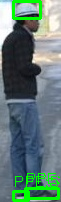

🖼️ Showing 001158_person2.jpg


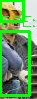

🖼️ Showing 005198_person0.jpg


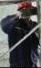

🖼️ Showing 001333_jpg.rf.25550b8186ab6e741765efbb21e9e59e_person0.jpg


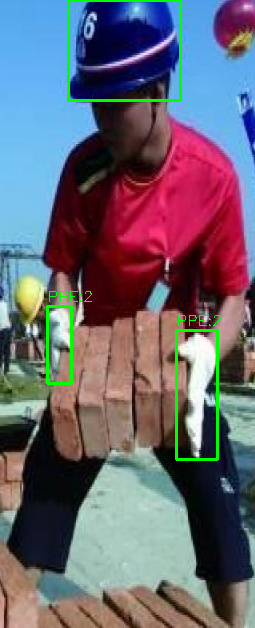

🖼️ Showing 001303_person3.jpg


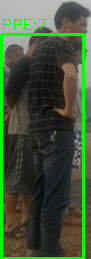

🖼️ Showing 001910_person4.jpg


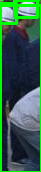

🖼️ Showing 001096_person2.jpg


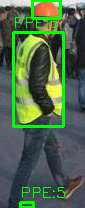

🖼️ Showing 001747_person3.jpg


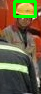

🖼️ Showing -2180-_png_jpg.rf.9d63bb305e7747d22fe9a196dcc5ce13_person3.jpg


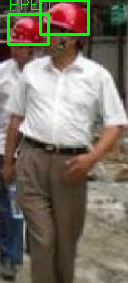

🖼️ Showing 001646_person0.jpg


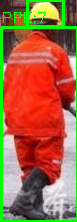

🖼️ Showing 001953_person4.jpg


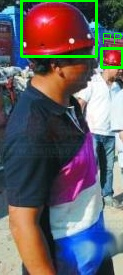

🖼️ Showing 001675_person3.jpg


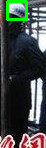

In [ ]:
import cv2
import os
import glob
import random

# Directories
img_dir = '/content/drive/MyDrive/Syook/datasets/data_split/PPE_train_data/images'
label_dir = '/content/drive/MyDrive/Syook/datasets/data_split/PPE_train_data/labels'

# Get list of all images
image_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
print(f"Total cropped images found: {len(image_paths)}")

# Choose random subset to visualize (or loop through all)
num_to_view = 20
sample_paths = random.sample(image_paths, num_to_view)

for img_path in sample_paths:
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(label_dir, base_name + ".txt")

    # Draw label boxes if label file exists
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                cls, xc, yc, bw, bh = map(float, line.strip().split())
                x1 = int((xc - bw / 2) * w)
                y1 = int((yc - bh / 2) * h)
                x2 = int((xc + bw / 2) * w)
                y2 = int((yc + bh / 2) * h)

                cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
                cv2.putText(img, f"PPE:{int(cls)}", (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

    else:
        print(f"⚠️ No label found for: {base_name}.jpg (empty label file)")

    # Show image
    from google.colab.patches import cv2_imshow
    print(f"🖼️ Showing {base_name}.jpg")
    cv2_imshow(img)
    cv2.waitKey(0)

cv2.destroyAllWindows()